In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

In [2]:
from sklearn.datasets import load_iris

iris = load_iris()

In [61]:
import pandas as pd

print(iris.data[:5]) # numpy ndarray
iris.frame = pd.DataFrame(iris.data, columns=iris.feature_names) # pandas DataFrame
iris.frame['label'] = iris.target_names[iris.target] # 품종 이름
iris.frame.to_csv('iris.csv', index=False)
# iris.frame.head(3)
# print(iris.feature_names)
# iris.frame.columns = ['꽃받침 길이', '꽃받침 너비', '꽃잎 길이', '꽃잎 너비', '품종']
# iris.frame.tail()
iris.frame.sample(5, random_state=1)

[[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
14,5.8,4.0,1.2,0.2,setosa
98,5.1,2.5,3.0,1.1,versicolor
75,6.6,3.0,4.4,1.4,versicolor
16,5.4,3.9,1.3,0.4,setosa
131,7.9,3.8,6.4,2.0,virginica


In [62]:
print(iris.target_names, end=' -> ') # 품종 이름
print(np.unique(iris.target)) # 집합

iris.frame['label'].value_counts()

['setosa' 'versicolor' 'virginica'] -> [0 1 2]


label
setosa        50
versicolor    50
virginica     50
Name: count, dtype: int64

## 탐색적 데이터 분석

Exploratory Data Analysis (EDA)

In [63]:
iris.frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   label              150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


In [64]:
iris.frame.drop(columns='label').mean()

sepal length (cm)    5.843333
sepal width (cm)     3.057333
petal length (cm)    3.758000
petal width (cm)     1.199333
dtype: float64

In [65]:
iris.frame.describe().round(2)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.00,150.00,150.00,150.00
mean,5.84,3.06,3.76,1.20
std,0.83,0.44,1.77,0.76
min,4.30,2.00,1.00,0.10
25%,5.10,2.80,1.60,0.30
50%,5.80,3.00,4.35,1.30
75%,6.40,3.30,5.10,1.80
max,7.90,4.40,6.90,2.50


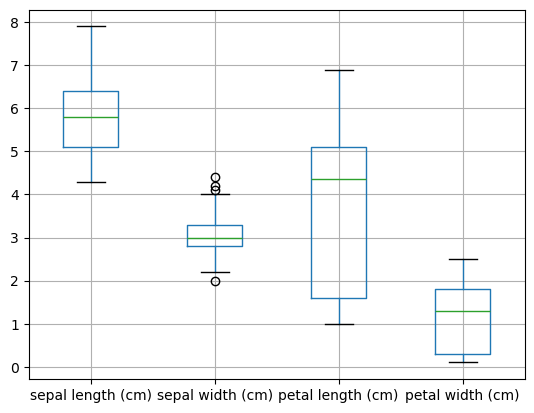

In [66]:
iris.frame.boxplot()
plt.show()

### 이상치 탐지

특이 Vs. 비정상?

In [73]:
x2 = iris.frame.iloc[:, 1]
Q1, Q3 = x2.quantile([0.25, 0.75])
IRQ = Q3 - Q1 # IQR: Interquartile Range; 통상적 구간의 크기
이상치하한 = Q1 - 1.5 * IRQ
이상치상한 = Q3 + 1.5 * IRQ
print(f'{이상치하한} < [{Q1} < x2 < {Q3}] < {이상치상한}')
# x2.describe().round(2)

정상필터 = x2.between(이상치하한, 이상치상한)
print(정상필터[:5])
print(정상필터.value_counts())
비정상필터 = np.logical_not(정상필터)
print(비정상필터.value_counts())
# True 인 값만 추출
iris.frame[비정상필터]

2.05 < [2.8 < x2 < 3.3] < 4.05
0    True
1    True
2    True
3    True
4    True
Name: sepal width (cm), dtype: bool
sepal width (cm)
True     146
False      4
Name: count, dtype: int64
sepal width (cm)
False    146
True       4
Name: count, dtype: int64


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label
15,5.7,4.4,1.5,0.4,setosa
32,5.2,4.1,1.5,0.1,setosa
33,5.5,4.2,1.4,0.2,setosa
60,5.0,2.0,3.5,1.0,versicolor


### 분포 확인

In [3]:
x1 = iris.frame.iloc[:, 0] # 첫 번째 열
x3 = iris.frame.iloc[:, 2] # 세 번째 열

plt.scatter(x1, x3, c=iris.target, cmap='brg')
plt.colorbar()
# 눈대중으로 분류 경계 그리기
plt.hlines(y=[2.5, 5.0], xmin=4.0, xmax=8.0)
plt.show()

AttributeError: 'NoneType' object has no attribute 'iloc'

## 모델

모형(model)은 데이터 분포에 대한 가정입니다.

In [89]:
samples = np.arange(10)

pd.DataFrame({
    '샘플': samples,
    'samples < 5': samples < 5,
    'np.where': np.where(samples < 5, -1, 1)
}).T

,0,1,2,3,4,5,6,7,8,9
샘플,0,1,2,3,4,5,6,7,8,9
samples < 5,True,True,True,True,True,False,False,False,False,False
np.where,-1,-1,-1,-1,-1,1,1,1,1,1


In [91]:
def 붓꽃분류(data):
    x3 = data[:, 2] # 세 번째 열
    품종분류 = np.where(x3 < 2.5, 0, np.where(x3 < 5.0, 1, 2))
    return 품종분류

예측 = 붓꽃분류(iris.data)
채점 = 예측 == iris.target
print(f'{sum(채점)}/{len(채점)} = {sum(채점)/len(채점):.0%}')
iris.frame.assign(예측=예측).sample(5, random_state=1)

142/150 = 95%


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),label,예측
14,5.8,4.0,1.2,0.2,setosa,0
98,5.1,2.5,3.0,1.1,versicolor,1
75,6.6,3.0,4.4,1.4,versicolor,1
16,5.4,3.9,1.3,0.4,setosa,0
131,7.9,3.8,6.4,2.0,virginica,2


## 종양 데이터

In [96]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
print(cancer.data.shape)
print(cancer.target_names, end=' -> ')
print(np.unique(cancer.target))

cancer.frame = pd.DataFrame(cancer.data, columns=cancer.feature_names)
cancer.frame['label'] = cancer.target_names[cancer.target]
cancer.frame.sample(5, random_state=1).round(2)

(569, 30)
['malignant' 'benign'] -> [0 1]


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,label
421,14.69,13.98,98.22,656.1,0.10,0.18,0.14,0.06,0.21,0.07,...,18.34,114.10,809.2,0.13,0.36,0.32,0.11,0.28,0.09,benign
47,13.17,18.66,85.98,534.6,0.12,0.12,0.12,0.07,0.21,0.07,...,27.95,102.80,759.4,0.18,0.42,0.50,0.21,0.39,0.12,malignant
292,12.95,16.02,83.14,513.7,0.10,0.08,0.06,0.03,0.17,0.06,...,19.93,88.81,585.4,0.15,0.21,0.22,0.11,0.34,0.10,benign
186,18.31,18.58,118.60,1041.0,0.09,0.08,0.08,0.06,0.16,0.05,...,26.36,139.20,1410.0,0.12,0.24,0.35,0.16,0.32,0.07,malignant
414,15.13,29.81,96.71,719.5,0.08,0.05,0.05,0.03,0.19,0.05,...,36.91,110.10,931.4,0.11,0.10,0.15,0.07,0.32,0.06,malignant


In [98]:
라벨별 = cancer.frame.groupby('label')
라벨별.mean().round(2)

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
label,,,,,,,,,,,,,,,,,,,,,
benign,12.15,17.91,78.08,462.79,0.09,0.08,0.05,0.03,0.17,0.06,...,13.38,23.52,87.01,558.90,0.12,0.18,0.17,0.07,0.27,0.08
malignant,17.46,21.60,115.37,978.38,0.10,0.15,0.16,0.09,0.19,0.06,...,21.13,29.32,141.37,1422.29,0.14,0.37,0.45,0.18,0.32,0.09


In [102]:
from sklearn.neighbors import KNeighborsClassifier

model = KNeighborsClassifier(n_neighbors=1)
model.fit(cancer.data, cancer.target) # 지도 학습

예측 = model.predict(cancer.data)
채점 = 예측 == cancer.target
print(f'{sum(채점)}/{len(채점)} = {sum(채점)/len(채점):.0%}')

c:\Users\student\miniconda3\envs\pyml\lib\site-packages\threadpoolctl.py:1226: RuntimeWarning: 
Found Intel OpenMP ('libiomp') and LLVM OpenMP ('libomp') loaded at
the same time. Both libraries are known to be incompatible and this
can cause random crashes or deadlocks on Linux when loaded in the
same Python program.
Using threadpoolctl may cause crashes or deadlocks. For more
information and possible workarounds, please see
    https://github.com/joblib/threadpoolctl/blob/master/multiple_openmp.md

  warnings.warn(msg, RuntimeWarning)


569/569 = 100%


## 훈련/시험 데이터

In [108]:
표본수 = len(cancer.data)
시험데이터비율 = 0.2 # 20%
시험데이터수 = round(표본수 * 시험데이터비율)
print(f'{시험데이터수}/{표본수}')

test_data = cancer.data[:시험데이터수]
test_target = cancer.target[:시험데이터수]

train_data = cancer.data[시험데이터수:]
train_target = cancer.target[시험데이터수:]

print(train_data.shape, test_data.shape)

114/569
(455, 30) (114, 30)
